**600035 - Numerical Modelling and Simulation**

**Assessment 2**

In [1]:
import numpy as np
import matplotlib.pyplot as plt

**Task 1a**

In [2]:
# Resonance energy (laboratory reference) (keV).
Eres_p = (37.0,
          156.2,
          189.5,
          259.7,
          436.0,
          479.0,
          639.0,
          661.0,
          1279.0)
Eres_p_error = [None,
                0.7,
                0.7,
                0.6,
                None,
                None,
                None,
                None,
                None]

# Set 5% error for energies without known error.
new_error = []
for energy, error in zip(Eres_p, Eres_p_error):
    if error is None:
        new_error.append(energy * 0.05)
    else:
        new_error.append(error)
Eres_p_error = new_error
        
# Resonance strengths (MeV).
ResStr = (3.1e-21,
          1.48e-13,
          1.87e-12,
          6.89e-12,
          0.079e-6,
          0.594e-6,
          2.45e-6,
          0.032e-6,
          10.8e-6)
ResStr_error = (1.2e-21,
                0.1e-13,
                0.06e-12,
                0.16e-12,
                0.006e-6,
                0.038e-6,
                0.18e-6,
                (0.024e-6,0.009e-6), # Asymmetric error (plus, minus)
                0.7e-6)

**Task 1b**

In [3]:
# Relevant constants.
M_p = 1.007316 # Proton mass (amu)
M_Ne = 21.991000 # Neon-22 mass (amu)

# Convert resonance energy to centre of mass reference (from labratory reference).
Eres_cm = [energy*M_Ne/(M_Ne+M_p) for energy in Eres_p]
Eres_cm_error = [energy_cm*(error/energy) for energy_cm, energy, error in zip(Eres_cm, Eres_p, Eres_p_error)]

# Convert to MeV.
Eres_cm = [energy*10**-3 for energy in Eres_cm]
Eres_cm_error = [error*10**-3 for error in Eres_cm_error]

**Task 1c**

In [4]:
# Define nuclear rate function.
def N_a(Eres,ResStr,M_A,M_b,T9):
    '''
    Calculates the nuclear rate N_a in cm^3.mol^-1.s^-1 for generic A+b -> c reation inside a star of given
    temperature T9 (in 10^9 K). M_A and M_b are the masses (in amu) of the A and b. ResStr is the strength
    of the -i resonance (in MeV) and Eres is the resonance energy (in MeV) from the center of mass reference.
    Returns the total reaction rate as well as a list of the component resonances.
    '''
    N_components = []
    k = 1.5399e11/(T9*M_A*M_b/(M_A+M_b))**(3/2) # constant for sum
    for Eres_i,ResStr_i in zip(Eres,ResStr):
        N_i =  k*(ResStr_i*np.exp(-11.605*(Eres_i/T9)))
        N_components.append(N_i)
    
    return sum(N_components),list(N_components)

**Task 2a**

In [5]:
# Create temperature range.
T9min, T9max = 0.01, 5.0 # temperature limits (10^9 K)
T9_array = np.logspace(np.log10(T9min),
                       np.log10(T9max),
                       100, # number of points in array
                       base = 10) # range evenly spaced on a base 10 logarithmic scale

# Calculate total rate and contributions at each temp.
N_totals = []
N_contributions = []

for temp in T9_array:
    total, contributions = N_a(Eres_cm,ResStr,M_Ne,M_p,temp)
    N_totals.append(total)
    N_contributions.append(contributions)

**Task 2b**

In [6]:
def non_negative_dist(datum,error,size):
    '''
    Returns a non-negative normal distribution of a specified size around the
    provided datum using the error as the standard deviation.
    Negative samples are rejected and resampled, ensuring the output is non-negative
    and of the correct size.
    If a list is provided for error, the first value will be taken to be positive error
    and the second value will be taken to be negative error.
    '''
    dist = []
    
    # Symmetric distributions.
    if type(error) == float:
        while len(dist) < size:

            # Create sample.
            sample = np.random.normal(datum,error)

            # Accept only non-negative samples.
            if sample >= 0:
                dist.append(sample)
                
    # Asymmetric distributions.
    else:
        while len(dist) < size/2:

            # Create sample from positive error.
            sample = np.random.normal(datum,error[0])

            # Accept only samples greater than the datum.
            if sample > datum:
                dist.append(sample)
       
        while len(dist) < size:

            # Create sample from negative error.
            sample = np.random.normal(datum,error[1])

            # Accept only non-negative samples less than the datum.
            if sample < datum and sample >= 0:
                dist.append(sample)

    return dist

# Create normal distributions for each resonance energy and strength.
Eres_cm_dists = []
ResStr_dists = []
for energy, energy_error, strength, strength_error in zip(Eres_cm, Eres_cm_error, ResStr, ResStr_error):
    Eres_cm_dists.append(non_negative_dist(energy, energy_error, 1000))
    ResStr_dists.append(non_negative_dist(strength, strength_error, 1000))

**Task 2c**

In [7]:
# Create lists of 120 lists of random selections from each normal distribution.
Eres_cm_selections = []
ResStr_selections = []

# Repeat selections 120 times.
for count in range(120):
    Eres_cm_choice = []
    ResStr_choice = []

    # Select random datum from each distribution in turn.
    for energy_dist, strength_dist in zip(Eres_cm_dists, ResStr_dists):
        Eres_cm_choice.append(np.random.choice(energy_dist))
        ResStr_choice.append(np.random.choice(strength_dist))
    
    Eres_cm_selections.append(Eres_cm_choice)
    ResStr_selections.append(ResStr_choice)

**Task 2d**

In [8]:
# Create a list of 120^2 = 14400 rates (using the resonance energies and strengths randomly selected above)
# for each temperature in T9_array.
N_array = []

for temp in T9_array:
    rates = []
    
    for energies in Eres_cm_selections:
        for strengths in ResStr_selections:
            rate = N_a(energies,strengths,M_Ne,M_p,temp)[0]
            rates.append(rate)

    N_array.append(rates)

**Task 2e**

In [9]:
# Find maximum and minimum nuclear rates for each temperature.
minimums, maximums = [], []
for rates in N_array:
    minimums.append(min(rates))
    maximums.append(max(rates))

**Task 3a**

In [10]:
# Create temperature list from T9 = 0.01 to T9 = 0.3.
T9_plot = []
for temp in T9_array:
    T9_plot.append(temp)
    if temp > 0.3:
        break
        
# From plot-relevant lists, take the values corresponding to these temperatures.
plotlength = len(T9_plot)

N_plot = N_array[:plotlength]
Nrec_plot = N_totals[:plotlength]
Ncon_plot = N_contributions[:plotlength]
Nmin_plot = minimums[:plotlength]
Nmax_plot = maximums[:plotlength]

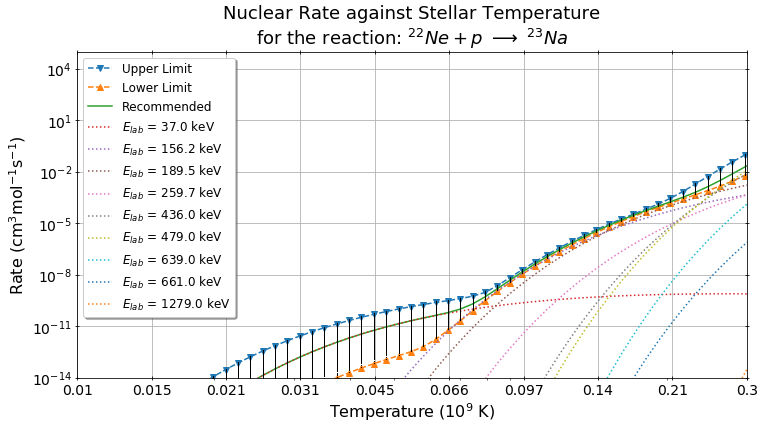

In [11]:
# Plot rates against temperature.
plt.figure(figsize=(12,6))

# Plot upper and lower limits.
plt.loglog(T9_plot, Nmax_plot,
           linestyle = '--',
           marker = 'v',
           label = 'Upper Limit')
plt.loglog(T9_plot, Nmin_plot,
           linestyle = '--',
           marker = '^',
           label = 'Lower Limit')

# Plot recommended rate.
plt.loglog(T9_plot, Nrec_plot,
           label = 'Recommended')

# Plot contributions from each resonance energy.
for i in range(len(Eres_p)):
    contributions_to_plot = [contributions[i] for contributions in Ncon_plot]
    plt.loglog(T9_plot, contributions_to_plot,
               linestyle = ':',
               label = '$E_{lab}$ = '+str(Eres_p[i])+' keV')

# Plot randomly selected rates.
plt.loglog(T9_plot, N_plot,
           'k, ')

# Set plot parameters.
plt.title('Nuclear Rate against Stellar Temperature\n\
for the reaction: $^{22}Ne + p$ $\longrightarrow$ $^{23}Na$',
          fontsize = '18')

# Temperature axis.
plt.xlim(0.01,0.3)
T9ticks = np.logspace(np.log10(0.01), np.log10(0.3), 10, base = 10)
T9labels = [f'{tick:.2}' for tick in T9ticks]
plt.xticks(T9ticks,
           T9labels,
           size = '14')
plt.xlabel('Temperature ($10^9$ K)',
           fontsize = '16')

# Rate axis.
plt.ylim(10e-15,10e4)
plt.yticks(size = '14')
plt.ylabel('Rate (cm$^3$mol$^{-1}$s$^{-1}$)',
           fontsize = '16')

plt.tick_params(direction='inout',right=True,top=True)
plt.legend(fontsize = '12',
           shadow = True)
plt.grid()

plt.savefig('Nuclear_Rates_fig1.png', bbox_inches='tight')
plt.show()

**Task 3b**

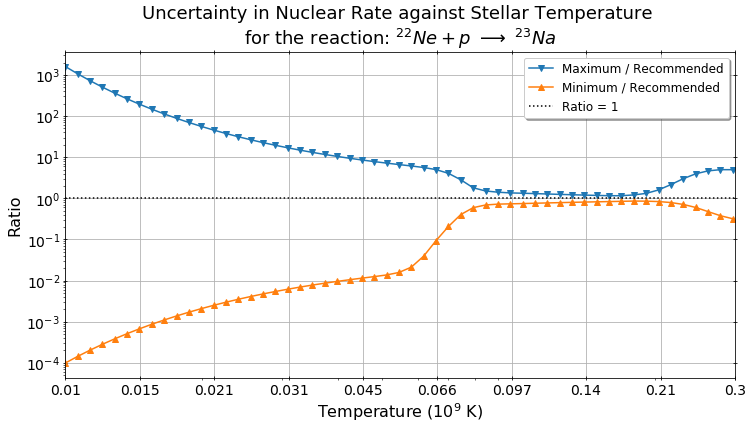

In [12]:
# Calculate the minimum and maximum rate as ratios over the recommended rate.
Nmin_ratio = [Nmin/Nrec for Nmin, Nrec in zip(Nmin_plot,Nrec_plot)]
Nmax_ratio = [Nmax/Nrec for Nmax, Nrec in zip(Nmax_plot,Nrec_plot)]

# Plot ratios.
plt.figure(figsize=(12,6))

plt.loglog(T9_plot, Nmax_ratio,
           label = 'Maximum / Recommended',
           marker = 'v')

plt.loglog(T9_plot, Nmin_ratio,
           label = 'Minimum / Recommended',
           marker = '^')

# Plot horizontal line at ratio = 1.
plt.axhline(1.,
            label = 'Ratio = 1',
            linestyle = ':',
            color = 'black')

# Set plot parameters.
plt.title('Uncertainty in Nuclear Rate against Stellar Temperature \n\
for the reaction: $^{22}Ne + p$ $\longrightarrow$ $^{23}Na$',
          fontsize = '18')

# Temperature axis.
plt.xlim(0.01, 0.3)
plt.xticks(T9ticks,
           T9labels,
           size = '14')
plt.xlabel('Temperature ($10^9$ K)',
           fontsize = '16')

# Ratio axis.
plt.yticks(size = '14')
plt.ylabel('Ratio',
           fontsize = '16')


plt.tick_params(direction='inout',right=True,top=True)
plt.legend(fontsize = '12',
           shadow = True)
plt.grid()

plt.savefig('Nuclear_Rates_fig2.png', bbox_inches='tight')
plt.show()

Nuclear rate, by the equation used, includes a coefficient which decreases exponentially as temperature increases. This coeffient reduces the significance of the values in the formula that carry uncertainty i.e. the observed values. 

At lower temperatures, nuclear rates are calculated more from these observed values than the constant or theoretical errorless values (particle masses, temperature, etc.). Thus, we expect highest uncertainty at the lowest temperature in the range.

In [13]:
# Determine location of highest uncertainty.
deviation_sums = [1/Nmin + Nmax for Nmin, Nmax in zip(Nmin_ratio, Nmax_ratio)]
max_deviation_index = deviation_sums.index(max(deviation_sums))
print(f'The most deviation occurs at Temperature = {T9_plot[max_deviation_index]} GK.')

The most deviation occurs at Temperature = 0.01 GK.


**Task 3c**

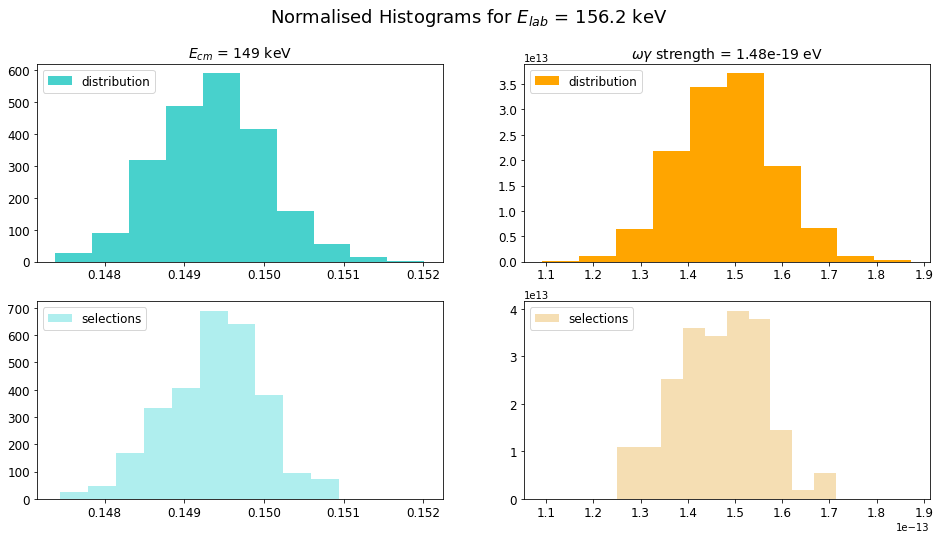

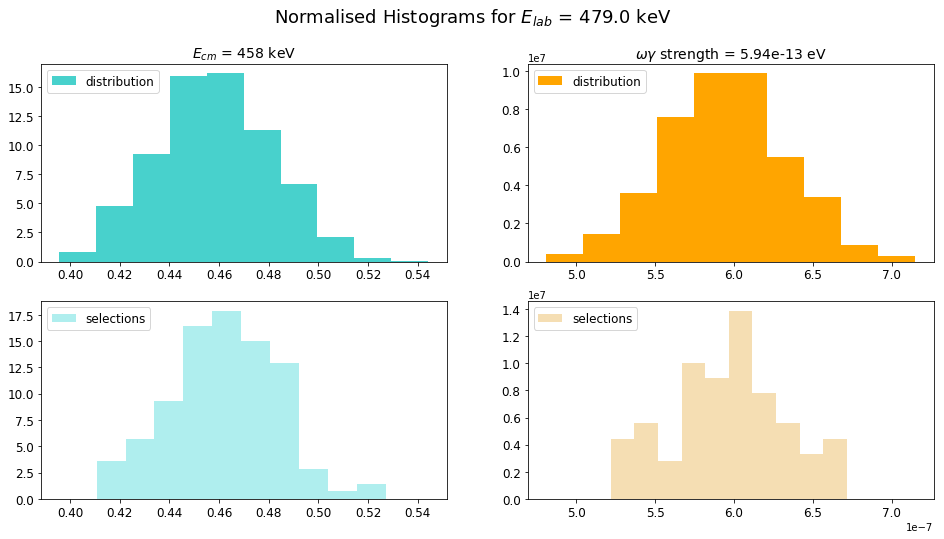

In [14]:
# Plot histograms.
for i in (1,5):
    fig, axarr = plt.subplots(2,
                              2,
                              figsize = (16,8),
                              sharex = 'col')

    plt.suptitle('Normalised Histograms for $E_{lab}$ = '+str(Eres_p[i])+' keV',
                 fontsize = '18')

    # Resonance Energy Distribution.
    axarr[0,0].set_title('$E_{cm}$ = '+f'{str(Eres_cm[i]*10**3):.3} keV',
                         fontsize = '14')
    axarr[0,0].hist(Eres_cm_dists[i],
                    density = True,
                    color = 'mediumturquoise',
                    label = 'distribution')
    axarr[0,0].tick_params(labelsize = '12',
                           labelbottom = True)
    axarr[0,0].legend(fontsize = '12',
                      loc = 2)

    # Resonance Energy Selections.
    axarr[1,0].hist([selections[i] for selections in Eres_cm_selections],
                    density = True,
                    color = 'paleturquoise',
                    label = 'selections')
    axarr[1,0].tick_params(labelsize = '12')
    axarr[1,0].legend(fontsize = '12',
                      loc = 2)

    # Resonance Strength Distribution.
    axarr[0,1].set_title('$\omega\gamma$ strength = '+f'{ResStr[i]*10**-6:.3} eV',
                         fontsize = '14')
    axarr[0,1].hist(ResStr_dists[i],
                    density = True,
                    color = 'orange',
                    label = 'distribution')
    axarr[0,1].tick_params(labelsize = '12',
                           labelbottom = True)
    axarr[0,1].legend(fontsize = '12',
                      loc = 2)

    # Resonance Strength Selections.
    axarr[1,1].hist([selections[i] for selections in ResStr_selections],
                    density = True,
                    color = 'wheat',
                    label = 'selections')
    axarr[1,1].tick_params(labelsize = '12')
    axarr[1,1].legend(fontsize = '12',
                      loc = 2)

    plt.savefig(f'Nuclear_Rates_fig3-{i}.png', bbox_inches='tight')
    plt.show()

**Task 4**

In [15]:
# Format data to be written.
header = '\
T (GK)    Nuclear Rates (cm^3.mol^-1.s^-1)\n\
          Minimum   Recommended   Maximum'
print(header)

data_to_write = []
for temp, Nmin, Nrec, Nmax in zip(T9_array, minimums, N_totals, maximums):
    line = f'{temp:.4f}    {Nmin:.2e}    {Nrec:.2e}    {Nmax:.2e}'
    data_to_write.append(line)
    print(line)

# Write data to file.
with open('table_rate.txt', 'w') as file:
    file.write(header)
    file.write('\n')
    for line in data_to_write:
        file.write(line)
        file.write('\n')

T (GK)    Nuclear Rates (cm^3.mol^-1.s^-1)
          Minimum   Recommended   Maximum
0.0100    7.35e-29    7.45e-25    1.20e-21
0.0106    1.18e-27    8.24e-24    8.80e-21
0.0113    1.59e-26    7.84e-23    5.69e-20
0.0121    1.82e-25    6.46e-22    3.27e-19
0.0129    1.78e-24    4.66e-21    1.68e-18
0.0137    1.51e-23    2.96e-20    7.77e-18
0.0146    1.12e-22    1.67e-19    3.25e-17
0.0155    7.31e-22    8.44e-19    1.24e-16
0.0165    4.23e-21    3.84e-18    4.34e-16
0.0176    2.18e-20    1.59e-17    1.40e-15
0.0187    1.02e-19    5.97e-17    4.17e-15
0.0199    4.28e-19    2.06e-16    1.16e-14
0.0212    1.64e-18    6.57e-16    3.00e-14
0.0226    5.77e-18    1.94e-15    7.31e-14
0.0241    1.87e-17    5.32e-15    1.68e-13
0.0256    5.59e-17    1.37e-14    3.63e-13
0.0273    1.56e-16    3.30e-14    7.46e-13
0.0291    4.06e-16    7.49e-14    1.46e-12
0.0310    9.92e-16    1.61e-13    2.73e-12
0.0330    2.28e-15    3.28e-13    4.87e-12
0.0351    4.96e-15    6.38e-13    8.36e-12
0.0374    1.